In [4]:
import pandas as pd
import numpy as np

In [24]:
scores_df = pd.read_csv('./scores.csv')
half_no_speech = scores_df[scores_df['no_speech'] == 0.5]
half_no_speech['no_speech'] = 0.0
half_no_speech_2 = half_no_speech.copy()
half_no_speech_2['no_speech'] = 1.0
scores_df = pd.concat([scores_df[scores_df['no_speech'] != 0.5], half_no_speech, half_no_speech_2])
scores_df['avg_prob'] = np.exp(scores_df['avg_logprob'])
scores_df['no_speech_prob_avg_prob'] = scores_df['no_speech_prob'] - scores_df['avg_prob']
scores_df

C:\Users\bum\AppData\Local\Temp\ipykernel_163932\2181574163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  half_no_speech['no_speech'] = 0.0


,avg_logprob,no_speech_prob,no_speech,avg_prob,no_speech_prob_avg_prob
0,-2.895649,0.492009,1.0,0.055263,0.436746
1,-0.794774,0.604776,1.0,0.451683,0.153093
2,-0.363985,0.525350,1.0,0.694902,-0.169552
3,-0.290838,0.521655,1.0,0.747637,-0.225982
5,-0.231551,0.033970,0.0,0.793302,-0.759332
...,...,...,...,...,...
355,-0.193849,0.007200,0.0,0.823782,-0.816582
356,-0.285576,0.012953,0.0,0.751581,-0.738628
357,-0.668011,0.922094,1.0,0.512727,0.409367
4,-0.971562,0.405391,0.0,0.378491,0.026900


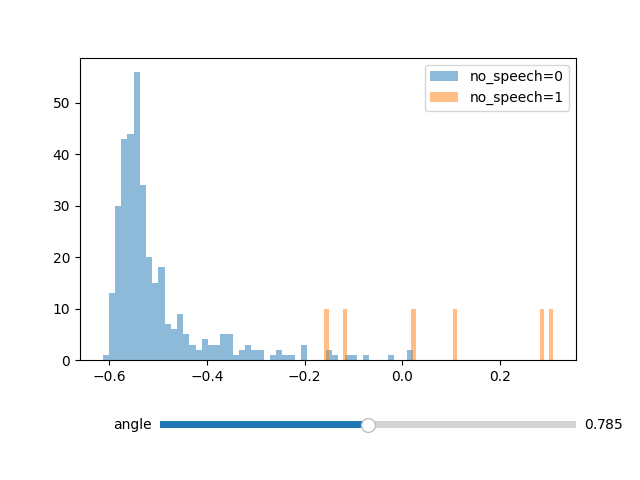

In [42]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib widget

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

slider_ax = plt.axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(slider_ax, 'angle', -np.pi/4, 3*np.pi/4, valinit=np.pi/4)

def update(val):
    scores_df['no_speech_prob_avg_prob'] = np.cos(slider.val) * scores_df['no_speech_prob'] - np.sin(slider.val) * scores_df['avg_prob']
    ax.clear()
    ax.hist(scores_df[scores_df['no_speech'] == 0]['no_speech_prob_avg_prob'], bins=50, alpha=0.5, label='no_speech=0')
    # no_speech==1 duplicate 10 times to make it more visible
    ax.hist(scores_df[scores_df['no_speech'] == 1]['no_speech_prob_avg_prob'].repeat(10), bins=50, alpha=0.5, label='no_speech=1')
    ax.legend(loc='upper right')
    fig.canvas.draw_idle()
    
slider.on_changed(update)
update(np.pi/4)

plt.show()

In [67]:
angle = 0.79037
np.cos(angle), -np.sin(angle), np.tan(angle)

(0.7035824367692272, -0.7106136465547762, 1.0099934413056637)

In [69]:
scores_df['no_speech_prob_avg_prob'] = scores_df['no_speech_prob'] - 1.01 * scores_df['avg_prob']
scores_df[scores_df['no_speech'] == 0]['no_speech_prob_avg_prob'].max(), scores_df[scores_df['no_speech'] == 1]['no_speech_prob_avg_prob'].min(), scores_df[scores_df['no_speech'] == 1]['no_speech_prob_avg_prob'].mean()

(0.024301150751189993, -0.23345869309625178, 0.10036062913489907)

## Detecting non-speech segments

1. $\texttt{no\_speech\_prob} - 1.01\cdot\exp(\texttt{avg\_prob}) > 0.1$
2. If not, check previous segment.
    1. If previous segment is non-speech and text is the same, mark as non-speech.

In [70]:
# Extract the segments that have a score of 1.0
# Match by avg_logprob and no_speech_prob
segments_df = pd.read_csv('./segments.csv')
segments_df = segments_df.merge(scores_df, on=['avg_logprob', 'no_speech_prob'])
segments_df = segments_df[segments_df['no_speech'] == 1.0]
segments_df['no_speech_detected'] = segments_df['no_speech_prob_avg_prob'] > 0.1
segments_df[['no_speech_detected', 'no_speech_prob_avg_prob', 'text']]

,no_speech_detected,no_speech_prob_avg_prob,text
0,True,0.436193,Maya plays ''Dance with the Stitch''
1,True,0.148576,Maya plays ''Dance with the Stitch''
2,False,-0.176501,Maya plays ''Dance with the Stitch''
3,False,-0.233459,Maya plays ''Dance with the Stitch''
5,False,0.023115,Maya plays ''Dance with the Stitch''
7,False,0.023115,Hello
9,False,0.023115,Meow
11,False,0.023115,Meow
13,False,0.023115,Hello
15,False,0.023115,Hello hello
